This notebook is a WIP (work in progress) notebook to redo `qh`, 
moving it away from it's current core of `py2http` and making it (hopefully) a better basis.

The better basis we want to have:
* use wrapping and routing tools of `i2`
* use `FastAPI` as the backend

Ideally, we'd like to facade our relationship with `FastAPI`, eventually.
But given the current context (new `i2mint` devs), we will not try to hard 
(not too the point of slowing us down too much).

Before `py2http`, there was `py2api`, and before that `flask_wrap`. 
We should look there for the good ideas, so we don't have to rethink them, or redo the same mistakes.


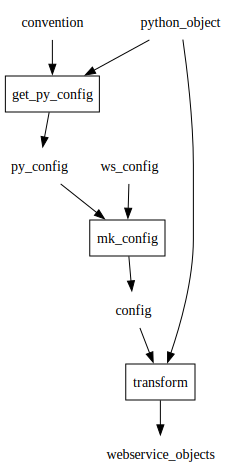

In [34]:
from meshed import code_to_dag

@code_to_dag
def i2i():
    webservice_objects = transform(python_object, config)
    py_config = get_py_config(python_object, convention)
    config = mk_config(py_config, ws_config)
    # config = mk_config(particular_config, convention)
i2i.dot_digraph()

# Refactoring a FastAPI app

We'll start with a simple `FastAPI` webservice, and gradually refactor towards 
increasingly more declarative architectures.

In [64]:
from wip_qh.fastapi_refactors.fastapi_refactor_00 import random_integer
assert random_integer(10, 10) == 10

from wip_qh.fastapi_refactors.fastapi_refactor_01 import app
from fastapi.testclient import TestClient

client = TestClient(app)
response_1 = client.get("/random_integer")
assert response_1.status_code == 200
assert isinstance(response_1.json(), int)

response_2 = client.get("/random_integer?smallest=11&highest=11")
assert response_2.json() == 11

assert client.get('/greeter/Ciao?n=2').json() == 'Ciao, world!\nCiao, world!'

In [63]:
from i2 import wrap

def foo(x:µ int):
    return x + 1

wrapped_foo = wrap(foo)

wrapped_foo.__name__



'foo'

## 00: Base functionality

Here, we'll intoduce a few objects that will be used as the "functional backend" of our webservices.
There's a couple of functions and a `backend_mall`, which is a `dict` that will hold other `dict`s:
These are supposed to represent facades to persisted data, siloed by user. 
We'll use the the `get_store` function to get the data corresponding to a particular user.


In [1]:
from wip_qh.fastapi_refactors.fastapi_refactor_00 import (
    random_integer,
    greeter,
    backend_mall,
    get_user_data,
)

In [2]:
random_integer()

7

In [3]:
random_integer(40, 45)

40

In [4]:
greeter('Hello')

'Hello, world!'

In [5]:
print(greeter('hi', 'bob', n=4))

hi, bob!
hi, bob!
hi, bob!
hi, bob!


In [6]:
backend_mall

{'alice': {'fruit': {'apple': 1, 'banana': 2},
  'planets': {'mercury': 10, 'venus': 20, 'earth': 30}},
 'bob': {'food': {'apple': 1, 'broccoli': 2, 'carrot': 3},
  'cars': {'ford': 10, 'toyota': 20},
  'colors': {'red': 100}}}

In [7]:
store = get_user_data('alice')
list(store)

['fruit', 'planets']

In [8]:
store['fruit']

{'apple': 1, 'banana': 2}

In [11]:
from wip_qh.fastapi_refactors.fastapi_refactor_01 import set_store_value

set_store_value(user='alice', key='fruit', value={'cherry': 'red'})

{'message': 'Value set successfully'}

In [12]:
store['fruit']

{'cherry': 'red'}

In [ ]:
from fastapi import Request

In [ ]:
def foo(x: int, y = 1, *, z = 'zebra'):
    return x, y, z

from fastapi import Request, Response

Args = tuple
Kwargs = dict
IngressType: Callable[[Request], Tuple[Args, Kwargs]]
FuncOutput = Any
EgressType: Callable[[FuncOutput], Response]
GetIngressType = Callable[[Callable], IngressType]
GetEgressType = Callable[[Callable], EgressType]

def ws_foo(request: Request):
    ingress = get_ingress(ws_foo)
    args, kwargs = ingress(request)
    return egress(foo(*args, **kwargs))


## 01: The first a-la-mano webservice

The way to make a web service with `FastAPI`
--as with many python-based modern web service frameworks--
is to decorate functions to map them to webservice routes. 

In the case of the `backend_mall`, we map it to routes corresponding to operations we want to provide as web services:

```python
@app.get("/store_list/{user}")
def get_store_list(user: str):
    store = store_getter(user)

    return list(store)

@app.get("/store_get/{user}/{key}")
def get_store_value(user: str, key: str):
    store = store_getter(user)
    return store[key]

# etc.
```

In [9]:
# We'll test the app with this:
from wip_qh.fastapi_refactors.test_fastapi_refactor_01 import test_fastapi_refactor_app

In [10]:
from wip_qh.fastapi_refactors.fastapi_refactor_01 import app

test_fastapi_refactor_app(app)

## 02: Factoring out the decorators

The first thing we'll do is to factor out the routing information, 
that is, the information carried by the decorators. 
There are two pieces of information there (at least in our example):
* the [http method](https://developer.mozilla.org/en-US/docs/Web/HTTP/Methods): `get` and `post` in our example, but there's also `put` and `delete` (and others, less frequent)
* the URL [path](https://www.watchguard.com/help/docs/help-center/en-US/Content/en-US/Fireware/proxies/http/http_req_url_paths_c.html)

So the first thing we'll do is to separate this information, mapping the decorated functions to them. 


In [8]:
from wip_qh.fastapi_refactors.fastapi_refactor_02 import app

test_fastapi_refactor_app(app)

## 03: Generalizing `apply_decorators_to_app` 

A direct generalization could look like this:

```python
def apply_decorators_to_app(app, configs):
    """Applying decorators based on the configs"""
    for function, config in configs.items():
        method = config['method']  # TODO: existence and value validation
        app_method = getattr(app, method)
        app_method(config['path'])(function)  # TODO: exitend to handle all app_method args
```

But we'll generalize more straight away.

Note that FastApi methods for http methods (get, post, put, etc.) are just convenience
methods that call the underlying 
[add_api_route](https://github.com/tiangolo/fastapi/blob/3425c834cc113060d00b8a295d3456eb306a109d/fastapi/routing.py#L831) 
method, which itself is a convenience method that uses the 
[APIRoute](https://github.com/tiangolo/fastapi/blob/3425c834cc113060d00b8a295d3456eb306a109d/fastapi/routing.py#L389) 
class to create a route. We'll use the latter directly,
so as to have more control over the configuration of the route.

So we'll have the configs (or at least the route specification part of it, 
which is all we dealt with for now) be a specification of the kwargs of `APIRoute`.

Note that I make this choice without knowing what "bulk parametrization" techniques 
`fastapi` offers out of the box. Perhaps I'll discover a better way to do this in 
the future (for example, I already see that there's a 
[APIRouter](https://fastapi.tiangolo.com/reference/apirouter/)
(note the `r` prefix) that is used to group *path operations* 
(but here we want to be able to group any operations, so as to develop concise dialects 
when our domain has repeated patterns we can exploit).

In [5]:
# reload test_fastapi_refactor_01
from importlib import reload
import wip_qh.fastapi_refactors.test_fastapi_refactor_01
import wip_qh.fastapi_refactors.fastapi_refactor_03
reload(wip_qh.fastapi_refactors.test_fastapi_refactor_01)
reload(wip_qh.fastapi_refactors.fastapi_refactor_03)

from wip_qh.fastapi_refactors.test_fastapi_refactor_01 import test_fastapi_refactor_app, apps

test_fastapi_refactor_app(apps[3])

    test_get_random_integer
    test_greeter
    test_get_store_list
    test_get_store_value
    test_set_store_value: 
   url='/store_set/alice?key=fruit': val={'some_key': 'some_value'}


In [2]:
from importlib import reload
import wip_qh.fastapi_refactors.fastapi_refactor_04
reload(wip_qh.fastapi_refactors.fastapi_refactor_04)
from wip_qh.fastapi_refactors.fastapi_refactor_04 import *

In [3]:
from wip_qh.fastapi_refactors.fastapi_refactor_04 import random_integer

expected_route_specs = {
    random_integer: {
        "api_route_kwargs": dict(methods=['GET'], path="/random_integer"),
        "defaults": {"smallest": Query(1), "highest": Query(10)},
    },
    greeter: {
        "api_route_kwargs": dict(methods=['GET'], path="/greeter/{greeting}"),
        "defaults": {"name": Query("world"), "n": Query(1)},
    },
    get_store_list: {
        "api_route_kwargs": {"methods": ['GET'], "path": "/store_list/{user}"}
    },
    get_store_value: {
        "api_route_kwargs": {"methods": ['GET'], "path": "/store_get/{user}"},
        "defaults": {"key": Query()},
    },
    set_store_value: {
        "api_route_kwargs": {"methods": ['POST'], "path": "/store_set/{user}"},
        "defaults": {"key": Query(), "value": Body(embed=True)},
    },
}

route_specs = {
    random_integer: {
        "api_route_kwargs": dict(path="/random_integer"),
        "defaults": {"smallest": Query(1), "highest": Query(10)},
    },
    greeter: {
        "api_route_kwargs": dict(path="/greeter/{greeting}"),
        "defaults": {"name": Query("world"), "n": Query(1)},
    },
    get_store_list: {
        "api_route_kwargs": {"path": "/store_list/{user}"}
    },
    get_store_value: {
        "api_route_kwargs": {"path": "/store_get/{user}"},
        "defaults": {"key": Query()},
    },
    set_store_value: {
        "api_route_kwargs": {"methods": ['POST'], "path": "/store_set/{user}"},
        "defaults": {"key": Query(), "value": Body(embed=True)},
    },
}

result = complete_route_specs(route_specs)
result




{<function wip_qh.fastapi_refactors.fastapi_refactor_00.random_integer(smallest: int = 1, highest: int = 10)>: {'api_route_kwargs': {'api_route_kwargs': {'path': '/random_integer'},
   'defaults': {'smallest': Query(1), 'highest': Query(10)},
   'methods': ['GET']},
  'defaults': {'smallest': Query(1), 'highest': Query(10)}},
 <function wip_qh.fastapi_refactors.fastapi_refactor_00.greeter(greeting: str, name: str = 'world', n: int = 1)>: {'api_route_kwargs': {'api_route_kwargs': {'path': '/greeter/{greeting}'},
   'defaults': {'name': Query(world), 'n': Query(1)},
   'methods': ['GET']},
  'defaults': {'name': Query(world), 'n': Query(1)}},
 <function wip_qh.fastapi_refactors.fastapi_refactor_00.get_store_list(user: str)>: {'api_route_kwargs': {'api_route_kwargs': {'path': '/store_list/{user}'},
   'methods': ['GET']}},
 <function wip_qh.fastapi_refactors.fastapi_refactor_00.get_store_value(user: str, key: str)>: {'api_route_kwargs': {'api_route_kwargs': {'path': '/store_get/{user}'},


In [5]:
expected_route_specs[set_store_value]['api_route_kwargs']

{'methods': ['POST'], 'path': '/store_set/{user}'}

In [ ]:
result[set_store_value]['api_route_kwargs']

In [2]:
test_fastapi_refactor_app(apps[3])

    test_get_random_integer
    test_greeter
    test_get_store_list
    test_get_store_value
    test_set_store_value: 
   url='/store_set/alice?key=fruit': val={'some_key': 'some_value'}


In [4]:
app = apps[3]
routes = {i: r for i, r in enumerate(app.routes)}
routes

{0: Route(path='/openapi.json', name='openapi', methods=['GET', 'HEAD']),
 1: Route(path='/docs', name='swagger_ui_html', methods=['GET', 'HEAD']),
 2: Route(path='/docs/oauth2-redirect', name='swagger_ui_redirect', methods=['GET', 'HEAD']),
 3: Route(path='/redoc', name='redoc_html', methods=['GET', 'HEAD']),
 4: APIRoute(path='/random_integer', name='random_integer', methods=['GET', 'POST']),
 5: APIRoute(path='/greeter', name='greeter', methods=['GET', 'POST']),
 6: APIRoute(path='/get_store_list', name='get_store_list', methods=['GET', 'POST']),
 7: APIRoute(path='/get_store_value', name='get_store_value', methods=['GET', 'POST']),
 8: APIRoute(path='/_set_store_value', name='_set_store_value', methods=['GET', 'POST'])}

In [ ]:
routes[5]

# Appendix

## Inspecting routes

In [1]:
# We'll test our http service at every step using test_fastapi_refactor_app
from wip_qh.fastapi_refactors.test_fastapi_refactor_01 import test_fastapi_refactor_app, apps
# test_fastapi_refactor_app(verbose=2)

In [2]:
app = apps[2]

In [3]:
app.routes

[Route(path='/openapi.json', name='openapi', methods=['GET', 'HEAD']),
 Route(path='/docs', name='swagger_ui_html', methods=['GET', 'HEAD']),
 Route(path='/docs/oauth2-redirect', name='swagger_ui_redirect', methods=['GET', 'HEAD']),
 Route(path='/redoc', name='redoc_html', methods=['GET', 'HEAD']),
 APIRoute(path='/random_integer', name='Wrap', methods=['GET']),
 APIRoute(path='/greeter/{greeting}', name='Wrap', methods=['GET']),
 APIRoute(path='/store_list/{user}', name='Wrap', methods=['GET']),
 APIRoute(path='/store_get/{user}', name='Wrap', methods=['GET']),
 APIRoute(path='/store_set/{user}', name='Wrap', methods=['POST'])]

**Q: Why are all the names of the routes "Wrap", even though the `__name__` of the endpoints are not?**

TODO: Figure out where `APIRoute` gets it's name from?

In [7]:
from fastapi.routing import APIRoute
api_route = app.routes[-1]
assert isinstance(api_route, APIRoute)
type(api_route).mro()

[fastapi.routing.APIRoute,
 starlette.routing.Route,
 starlette.routing.BaseRoute,
 object]

In [8]:
api_route.endpoint

<i2.Wrap _set_store_value(user: str, key: str = Query(PydanticUndefined), value: Any = Body(PydanticUndefined))>

In [9]:
api_route.endpoint.__name__

'_set_store_value'

In [11]:
# could it be that the fastapi process gets it's name from the type of the endpoint?
type(api_route.endpoint).__name__

'Wrap'

In [22]:
# print the attributes of the api_route object
# keeping the line length under 80 characters
attrs = [x for x in dir(api_route) if not x.startswith('_')]
print('\n'.join(__import__('textwrap').wrap('\t'.join(attrs), 80)))

app     body_field      callbacks       dependant       dependencies
dependency_overrides_provider   deprecated      description     endpoint
generate_unique_id_function     get_route_handler       handle
include_in_schema       matches methods name    openapi_extra   operation_id
param_convertors        path    path_format     path_regex      response_class
response_description    response_field  response_fields response_model
response_model_by_alias response_model_exclude  response_model_exclude_defaults
response_model_exclude_none     response_model_exclude_unset
response_model_include  responses       secure_cloned_response_field
status_code     summary tags    unique_id       url_path_for


In [28]:
import pandas as pd

pd.Series({a: getattr(api_route, a) for a in attrs})

app                                <function request_response.<locals>.app at 0x1...
body_field                         ModelField(field_info=Body(PydanticUndefined),...
callbacks                                                                         []
dependant                          <fastapi.dependencies.models.Dependant object ...
dependencies                                                                      []
dependency_overrides_provider      <fastapi.applications.FastAPI object at 0x120e...
deprecated                                                                      None
description                                                                         
endpoint                           <i2.Wrap _set_store_value(user: str, key: str ...
generate_unique_id_function        <fastapi.datastructures.DefaultPlaceholder obj...
get_route_handler                  <bound method APIRoute.get_route_handler of AP...
handle                             <bound method Route.handle of 

In [32]:
from i2 import Sig

Sig(app.api_route).parameters['methods']

<Parameter "methods: Optional[List[str]] = None">

In [39]:
def foo(x: int, y = 1, *, z = 'zebra'):
    return x, y, z

Sig(app.add_api_route).parameters

app.add_api_route(path='/', endpoint=foo, methods=['GETT'])

## Getting the signatures of the different methods

In [12]:
method_strings = ['get', 'post', 'put', 'delete', 'options', 'head', 'patch', 'trace']

from fastapi import FastAPI
from i2 import Sig

app = FastAPI()

def method_sigs(method_strings=method_strings):
    for method_name in method_strings:
        method_func = getattr(app, method_name)
        yield method_name, Sig(method_func)

method_and_sigs = dict(method_sigs())


In [44]:
from fastapi import FastAPI

http_method_arg_names = [p.name for p in Sig(FastAPI.get).params[1:]]
len(http_method_arg_names)

23

In [45]:
t = [p.name for p in Sig(FastAPI.add_api_route).params[1:]]
len(t)


24

In [46]:
set(t) - set(http_method_arg_names)

{'endpoint', 'methods'}

In [47]:
set(http_method_arg_names) - set(t)

{'callbacks'}

In [50]:
type(app.routes[-1])

fastapi.routing.APIRoute

In [51]:
from fastapi import FastAPI
from fastapi.routing import APIRoute


api_route_arg_names = [p.name for p in Sig(APIRoute).params]
api_route_arg_names

['path',
 'endpoint',
 'response_model',
 'status_code',
 'tags',
 'dependencies',
 'summary',
 'description',
 'response_description',
 'responses',
 'deprecated',
 'name',
 'methods',
 'operation_id',
 'response_model_include',
 'response_model_exclude',
 'response_model_by_alias',
 'response_model_exclude_unset',
 'response_model_exclude_defaults',
 'response_model_exclude_none',
 'include_in_schema',
 'response_class',
 'dependency_overrides_provider',
 'callbacks',
 'openapi_extra',
 'generate_unique_id_function']

In [52]:
set(api_route_arg_names) - set(Sig(FastAPI.get))

{'dependency_overrides_provider', 'endpoint', 'methods'}

In [53]:
set(Sig(FastAPI.get)) - set(api_route_arg_names)

{'self'}

In [72]:
Sig(FastAPI).parameters
t = FastAPI()
t.routes

tuple(Sig(APIRoute).names)

('path',
 'endpoint',
 'response_model',
 'status_code',
 'tags',
 'dependencies',
 'summary',
 'description',
 'response_description',
 'responses',
 'deprecated',
 'name',
 'methods',
 'operation_id',
 'response_model_include',
 'response_model_exclude',
 'response_model_by_alias',
 'response_model_exclude_unset',
 'response_model_exclude_defaults',
 'response_model_exclude_none',
 'include_in_schema',
 'response_class',
 'dependency_overrides_provider',
 'callbacks',
 'openapi_extra',
 'generate_unique_id_function')

In [ ]:
from typing import Literal

t = Literal['path',
 'endpoint',
 'response_model',
 'status_code',
 'tags',
 'dependencies',
 'summary',
 'description',
 'response_description',
 'responses',
 'deprecated',
 'name',
 'methods',
 'operation_id',
 'response_model_include',
 'response_model_exclude',
 'response_model_by_alias',
 'response_model_exclude_unset',
 'response_model_exclude_defaults',
 'response_model_exclude_none',
 'include_in_schema',
 'response_class',
 'dependency_overrides_provider',
 'callbacks',
 'openapi_extra',
 'generate_unique_id_function']

In [15]:
# make a table where columns are the request parameters classes and rows are the arguments
import pandas as pd

method_arg_names = {
    method_name: {p.name: p for p in sig.params} 
    for method_name, sig in method_and_sigs.items()
}
df = pd.DataFrame(method_arg_names)
df = df.fillna('')
# replace all the non-empty strings with 'x'
df.map(lambda x: 'x' if x else '')

,get,post,put,delete,options,head,patch,trace
path,x,x,x,x,x,x,x,x
response_model,x,x,x,x,x,x,x,x
status_code,x,x,x,x,x,x,x,x
tags,x,x,x,x,x,x,x,x
dependencies,x,x,x,x,x,x,x,x
summary,x,x,x,x,x,x,x,x
description,x,x,x,x,x,x,x,x
response_description,x,x,x,x,x,x,x,x
responses,x,x,x,x,x,x,x,x
deprecated,x,x,x,x,x,x,x,x


In [24]:
# def list_of_unique_elements(lists):
#     seen = set()
#     return [elem for sublist in lists for elem in sublist if elem not in seen and not seen.add(elem)]

# # list all unique parameters in method_and_sigs.values()
# all_sig = Sig(list_of_unique_elements([p.params for p in method_and_sigs.values()]))
# all_sig

In [21]:
method_and_sigs['get']

<Sig (path: typing.Annotated[str, Doc('\n                The URL path to be used for this *path operation*.\n\n                For example, in `http://example.com/items`, the path is `/items`.\n                ')], *, response_model: Annotated[Any, Doc("\n                The type to use for the response.\n\n                It could be any valid Pydantic *field* type. So, it doesn't have to\n                be a Pydantic model, it could be other things, like a `list`, `dict`,\n                etc.\n\n                It will be used for:\n\n                * Documentation: the generated OpenAPI (and the UI at `/docs`) will\n                    show it as the response (JSON Schema).\n                * Serialization: you could return an arbitrary object and the\n                    `response_model` would be used to serialize that object into the\n                    corresponding JSON.\n                * Filtering: the JSON sent to the client will only contain the data\n                   

## Getting information on the argument of "request parameters"

In [9]:
from i2 import Sig 

from fastapi import Path, Query, Header, Cookie, Body, Form, File

request_parameters_classes = [Path, Query, Header, Cookie, Body, Form, File]

In [5]:
path_sig = Sig(Path)
path_sig.params[:4]

[<Parameter "default: Annotated[Any, Doc("\n            Default value if the parameter field is not set.\n\n            This doesn't affect `Path` parameters as the value is always required.\n            The parameter is available only for compatibility.\n            ")] = Ellipsis">,
 <Parameter "default_factory: Annotated[Optional[Callable[[], Any]], Doc("\n            A callable to generate the default value.\n\n            This doesn't affect `Path` parameters as the value is always required.\n            The parameter is available only for compatibility.\n            ")] = PydanticUndefined">,
 <Parameter "alias: Annotated[Optional[str], Doc("\n            An alternative name for the parameter field.\n\n            This will be used to extract the data and for the generated OpenAPI.\n            It is particularly useful when you can't use the name you want because it\n            is a Python reserved keyword or similar.\n            ")] = None">,
 <Parameter "alias_priority: Anno

In [6]:
assert path_sig.params[0].name == 'default'
assert path_sig.params[0].kind == path_sig.POSITIONAL_OR_KEYWORD
assert path_sig.params[0].default == Ellipsis
path_sig.params[0].annotation


typing.Annotated[typing.Any, Doc("\n            Default value if the parameter field is not set.\n\n            This doesn't affect `Path` parameters as the value is always required.\n            The parameter is available only for compatibility.\n            ")]

In [8]:
path_sig = Sig(Path)
query_sig = Sig(Query)
assert path_sig.params[0].name == query_sig.params[0].name == 'default'
assert not (path_sig.params[0].annotation == query_sig.params[0].annotation)
query_sig.params[0].annotation

typing.Annotated[typing.Any, Doc('\n            Default value if the parameter field is not set.\n            ')]

In [61]:
# Make a dictionary of the request parameters classes' arguments
sigs = {cls.__name__: Sig(cls) for cls in request_parameters_classes}
request_params_kwargs = {
    name: {
        p.name: p for p in sig.params
    } 
    for name, sig in sigs.items()
}
list(request_params_kwargs['Path'])

['default',
 'default_factory',
 'alias',
 'alias_priority',
 'validation_alias',
 'serialization_alias',
 'title',
 'description',
 'gt',
 'ge',
 'lt',
 'le',
 'min_length',
 'max_length',
 'pattern',
 'regex',
 'discriminator',
 'strict',
 'multiple_of',
 'allow_inf_nan',
 'max_digits',
 'decimal_places',
 'examples',
 'example',
 'openapi_examples',
 'deprecated',
 'include_in_schema',
 'json_schema_extra',
 'extra']

In [77]:
# make a table where columns are the request parameters classes and rows are the arguments
import pandas as pd

df = pd.DataFrame(request_params_kwargs)
df = df.fillna('')
# replace all the non-empty strings with 'x'
df.map(lambda x: 'x' if x else '')



,Path,Query,Header,Cookie,Body,Form,File
default,x,x,x,x,x,x,x
default_factory,x,x,x,x,x,x,x
alias,x,x,x,x,x,x,x
alias_priority,x,x,x,x,x,x,x
validation_alias,x,x,x,x,x,x,x
serialization_alias,x,x,x,x,x,x,x
title,x,x,x,x,x,x,x
description,x,x,x,x,x,x,x
gt,x,x,x,x,x,x,x
ge,x,x,x,x,x,x,x


In [3]:
from i2 import Sig 
import pandas as pd
from fastapi import Path, Query, Header, Cookie, Body, Form, File


from wip_qh.fastapi_refactors.fastapi_util import (
    request_parameters_classes, request_params_sigs, request_params_kwargs
)

# make a table where columns are the request parameters classes and rows are the arguments
df = pd.DataFrame(request_params_kwargs)
df = df.fillna('')

display = print
# from pyperclip import copy as display  # uncomment to copy to clipboard instead of printing
display(df.map(lambda x: 'x' if x else '').to_markdown())

|                     | Path   | Query   | Header   | Cookie   | Body   | Form   | File   |
|:--------------------|:-------|:--------|:---------|:---------|:-------|:-------|:-------|
| default             | x      | x       | x        | x        | x      | x      | x      |
| default_factory     | x      | x       | x        | x        | x      | x      | x      |
| alias               | x      | x       | x        | x        | x      | x      | x      |
| alias_priority      | x      | x       | x        | x        | x      | x      | x      |
| validation_alias    | x      | x       | x        | x        | x      | x      | x      |
| serialization_alias | x      | x       | x        | x        | x      | x      | x      |
| title               | x      | x       | x        | x        | x      | x      | x      |
| description         | x      | x       | x        | x        | x      | x      | x      |
| gt                  | x      | x       | x        | x        | x      | x     

# Scrap

## Old stuff

In [2]:
from wip_qh.fastapi_refactors.fastapi_refactor_00 import StoreAccess

s = StoreAccess.from_uri()
s.write('test_key', 'test_value_1111')
s.read('test_key')

'test_value_1111'

In [ ]:
from wip_qh.store_dispatch_2 import app
from wip_qh.store_dispatch_2 import *

@app.get("/list/{uri}")
async def list_keys(uri: str):
    store = StoreAccess.from_uri(uri)
    return store.list()


@app.get("/read/{uri}/{key}")
async def read_key(uri: str, key: str):
    try:
        store = StoreAccess.from_uri(uri)
        return store.read(key)
    except KeyError:
        raise HTTPException(status_code=404, detail="Key not found")

@app.post("/write/{uri}")
async def write_key(uri: str, body: WriteRequestBody):
    store = StoreAccess.from_uri(uri)
    store.write(body.key, body.value)

app = mk_app(
    constructor,
    constructor_arg_name='uri',
    routes={
        'list': {'route': "/list/{uri}", 'args': None, 'method': 'get'},
        'read': {'route': "/read/{uri}/{key}", 'args': ['key'], 'method': 'get'},
        'write': {'route': "/read/{uri}", 'args': ['body.key', 'body.value'], 'method': 'post'},

    }
)
   

NameError: name 'app' is not defined

Hello world!
Hello world!
Hello world!
Hello world!


In [5]:
from fastapi.testclient import TestClient

from wip_qh.store_dispatch_2 import app

client = TestClient(app)

response = client.get("/list/test_uri")
response

<Response [422 Unprocessable Entity]>

In [ ]:
print(response.status_code)
response.json()

422


{'detail': [{'type': 'missing',
   'loc': ['query', 'args'],
   'msg': 'Field required',
   'input': None,
   'url': 'https://errors.pydantic.dev/2.5/v/missing'},
  {'type': 'missing',
   'loc': ['query', 'kwargs'],
   'msg': 'Field required',
   'input': None,
   'url': 'https://errors.pydantic.dev/2.5/v/missing'}]}

In [ ]:
from wip_qh.simple_fastapi_dispatch import app

client = TestClient(app)

r = client.get("/poke/")
assert r.json() == 'here is a peek'

r = client.get("/foo/")


TypeError: Sig.map_arguments() got an unexpected keyword argument 'x'